# Introduction

In this notebook we try to classify images with a CNN.

Before, we have tried to classify images with a MLP which did not work since MLP do not provide basic operations as pooling in order to foster a translation invariant representation.

# Check dependencies

In [4]:
import matplotlib
print(matplotlib.__version__)

import numpy as np
print(np.__version__)

import cv2
print(cv2.__version__)

import pickle
print(pickle.format_version)

import tensorflow
print(tensorflow.__version__)

3.3.2
1.19.2
4.5.1
4.0
2.3.0


# Load in the image dataset generated before

In [5]:
fname = "../01_cnn_generating_image_data/persons_icons_dataset.pkl"

fobj = open(fname, "rb")
dataset = pickle.load(fobj)
fobj.close()

In [6]:
type(dataset)

list

In [7]:
len(dataset)

2

In [8]:
list_imgs, list_labels = dataset

In [9]:
len(list_imgs)

500

In [10]:
len(list_labels)

500

In [11]:
list_imgs[:2]

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])]

In [12]:
list_labels[:2]

[4, 0]

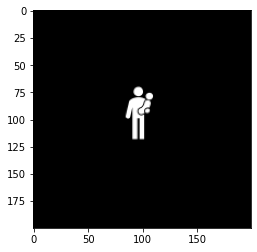

In [13]:
import matplotlib.pyplot as plt

plt.imshow(list_imgs[0], cmap="gray")
plt.show()

In [14]:
label = list_labels[0]
label

4

In [15]:
min(list_labels), max(list_labels)

(0, 4)

In [16]:
nr_object_classes = max(list_labels)+1
nr_object_classes

5

# Prepare input and output matrices

For training a MLP, where the inputs are 1-dimensional we need a 2D-matrix (for batch-learning) in Keras: in each row of this 2D-matrix there was a single input vector stored.

For training a CNN with color images, you need a 4-dimensional input tensor in Keras!

Here is what each of these 4 dimensions is used for:

    dim #1: sample nr
    dim #2: height of the image
    dim #3: width of the image
    dim #4: depth of the image (e.g. 3 color channels; RGB)
    
OK. So let us prepare a 4D input tensor!

In [17]:
example_img = list_imgs[0]

In [18]:
type(example_img)

numpy.ndarray

In [19]:
example_img.shape

(200, 200)

In [20]:
nr_images = len(list_imgs)
nr_images

500

In [21]:
img_height = example_img.shape[0]
img_width  = example_img.shape[1]
img_depth  = 1

In [22]:
X = np.zeros((nr_images, img_height, img_width, img_depth))

In [23]:
X.shape

(500, 200, 200, 1)

In [24]:
X.size

20000000

There it is! A 4D input tensor. But up to now only zeros...

The output tensor on the other hand is still a 2D output tensor: in each row we store for each of the sample images a one-hot encoded vector that encodes which object class is present.

In [25]:
Y = np.zeros((nr_images, nr_object_classes))

In [26]:
def get_one_hot_vec(length, pos):
    vec = np.zeros(length)
    vec[pos] = 1
    return vec

In [27]:
test_vec = get_one_hot_vec(nr_object_classes, 4)
test_vec

array([0., 0., 0., 0., 1.])

In [28]:
for img_nr in range(0, nr_images):
    
    # get the next image
    img = list_imgs[img_nr]
        
    # save image in 4D input tensor
    X[img_nr,:,:,0] = img
    
    # get label (0,1,2,3,or 4)
    label = list_labels[img_nr]
    
    # save label as one-hot encoded vector    
    Y[img_nr,:] = get_one_hot_vec(nr_object_classes, label)

# Split image data into train and test data

In [29]:
N = len(X)
N

500

In [30]:
half = int(N/2)
half

250

In [31]:
X_train = X[:half]
Y_train = Y[:half]

X_test  = X[half:]
Y_test  = Y[half:]

In [32]:
X_train.shape

(250, 200, 200, 1)

In [33]:
X_test.shape

(250, 200, 200, 1)

In [34]:
len(Y_train)

250

In [35]:
len(Y_test)

250

# Build the CNN model

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras import losses

K.clear_session()

model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(1024, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(10, activation='relu'))
nr_output_neurons = nr_object_classes
model.add(layers.Dense(nr_output_neurons))

model.compile(loss=losses.mean_squared_error, optimizer='sgd')
#model.compile(loss=losses.categorical_crossentropy, optimizer='sgd')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 256)       2

# Test the model before training

In [37]:
def test_model(model, X_test, Y_test, show_some_predictions=False):
    preds = model.predict(X_test)
    
    nr_test_samples = Y_test.shape[0]
    correct = 0
    for test_nr in range(0,nr_test_samples):        
        should_label = np.argmax(Y_test[test_nr])
        is_label     = np.argmax(preds[test_nr])
        
        if should_label==is_label:
            correct += 1
        
        if show_some_predictions and test_nr<10:
            print("Should: {0} vs. Is: {1}".format(Y_test[test_nr], preds[test_nr]))
            print("Should label: {0} vs. Is label: {1}\n".format(should_label, is_label))            
            
    correctly_classified_percent = (correct / nr_test_samples) * 100.0
    print("Correctly classified: {0:.2f}".format(correctly_classified_percent))

In [38]:
test_model(model, X_test, Y_test, show_some_predictions=True)

Should: [0. 0. 0. 0. 1.] vs. Is: [ 0.0088239   0.01539834  0.00867434 -0.0084831  -0.00285053]
Should label: 4 vs. Is label: 1

Should: [0. 1. 0. 0. 0.] vs. Is: [ 0.00810043  0.01662103  0.00873565 -0.00877241 -0.00236019]
Should label: 1 vs. Is label: 1

Should: [0. 0. 0. 1. 0.] vs. Is: [ 0.01787737  0.01746128  0.01197211 -0.01470235 -0.01511434]
Should label: 3 vs. Is label: 0

Should: [0. 0. 1. 0. 0.] vs. Is: [ 0.0066409   0.01180218  0.00715652 -0.00275813 -0.00283211]
Should label: 2 vs. Is label: 1

Should: [0. 1. 0. 0. 0.] vs. Is: [ 0.01578288  0.00863926  0.01449833 -0.01498519 -0.00595724]
Should label: 1 vs. Is label: 0

Should: [1. 0. 0. 0. 0.] vs. Is: [ 0.01597716  0.01770471  0.01034985 -0.01258719 -0.01495829]
Should label: 0 vs. Is label: 1

Should: [0. 0. 0. 0. 1.] vs. Is: [ 0.01495587  0.00961137  0.01302272 -0.00795512 -0.00913687]
Should label: 4 vs. Is label: 0

Should: [0. 0. 0. 1. 0.] vs. Is: [ 0.00463917  0.00576851  0.00446227 -0.0044253  -0.00496477]
Should la

In [39]:
test_model(model, X_train, Y_train, show_some_predictions=True)

Should: [0. 0. 0. 0. 1.] vs. Is: [ 0.01879367  0.01941035  0.0128591  -0.02179338 -0.01295285]
Should label: 4 vs. Is label: 1

Should: [1. 0. 0. 0. 0.] vs. Is: [ 0.01678548  0.02534129  0.01226233 -0.02541969 -0.00868633]
Should label: 0 vs. Is label: 1

Should: [0. 0. 1. 0. 0.] vs. Is: [ 0.01148124  0.02275942  0.01088323 -0.01676342 -0.00238606]
Should label: 2 vs. Is label: 1

Should: [0. 0. 1. 0. 0.] vs. Is: [ 0.01078438  0.01970245  0.0077471  -0.01585162 -0.00836285]
Should label: 2 vs. Is label: 1

Should: [0. 0. 0. 0. 1.] vs. Is: [ 0.00551626  0.0105949   0.00535586 -0.00545695 -0.001534  ]
Should label: 4 vs. Is label: 1

Should: [0. 0. 0. 0. 1.] vs. Is: [ 0.0163074   0.00617254  0.01302704 -0.01657965 -0.00597606]
Should label: 4 vs. Is label: 0

Should: [0. 1. 0. 0. 0.] vs. Is: [ 0.00745304  0.0153678   0.00819627 -0.00833458 -0.00275037]
Should label: 1 vs. Is label: 1

Should: [0. 0. 0. 0. 1.] vs. Is: [ 0.00835838  0.01152158  0.00545904 -0.00573125 -0.01120324]
Should la

# Train the CNN

In [40]:
from datetime import datetime
datetime.now()

datetime.datetime(2021, 5, 18, 15, 53, 41, 461758)

In [41]:
datetime.now()
history = model.fit(X_train,Y_train, epochs=4000, verbose=1)
datetime.now()

Epoch 1/4000
8/8 [==============================] - 7s 830ms/step - loss: 0.1970
Epoch 2/4000
8/8 [==============================] - 7s 878ms/step - loss: 0.1918
Epoch 3/4000
8/8 [==============================] - 7s 864ms/step - loss: 0.1870
Epoch 4/4000
8/8 [==============================] - 7s 873ms/step - loss: 0.1831
Epoch 5/4000
8/8 [==============================] - 7s 897ms/step - loss: 0.1797
Epoch 6/4000
8/8 [==============================] - 7s 878ms/step - loss: 0.1768
Epoch 7/4000
8/8 [==============================] - 7s 872ms/step - loss: 0.1743
Epoch 8/4000
8/8 [==============================] - 7s 854ms/step - loss: 0.1722
Epoch 9/4000
8/8 [==============================] - 7s 861ms/step - loss: 0.1704
Epoch 10/4000
8/8 [==============================] - 7s 872ms/step - loss: 0.1688
Epoch 11/4000
8/8 [==============================] - 7s 870ms/step - loss: 0.1675
Epoch 12/4000
8/8 [==============================] - 7s 871ms/step - loss: 0.1663
Epoch 13/4000
8/8 [======

8/8 [==============================] - 7s 833ms/step - loss: 0.1530
Epoch 102/4000
8/8 [==============================] - 7s 828ms/step - loss: 0.1529
Epoch 103/4000
8/8 [==============================] - 7s 823ms/step - loss: 0.1528
Epoch 104/4000
8/8 [==============================] - 6s 793ms/step - loss: 0.1527
Epoch 105/4000
8/8 [==============================] - 6s 782ms/step - loss: 0.1526
Epoch 106/4000
8/8 [==============================] - 6s 784ms/step - loss: 0.1525
Epoch 107/4000
8/8 [==============================] - 6s 789ms/step - loss: 0.1525
Epoch 108/4000
8/8 [==============================] - 6s 801ms/step - loss: 0.1524
Epoch 109/4000
8/8 [==============================] - 6s 794ms/step - loss: 0.1522
Epoch 110/4000
8/8 [==============================] - 6s 779ms/step - loss: 0.1521
Epoch 111/4000
8/8 [==============================] - 6s 791ms/step - loss: 0.1521
Epoch 112/4000
8/8 [==============================] - 6s 795ms/step - loss: 0.1520
Epoch 113/4000
8/8 

8/8 [==============================] - 6s 785ms/step - loss: 0.1334
Epoch 200/4000
8/8 [==============================] - 6s 789ms/step - loss: 0.1330
Epoch 201/4000
8/8 [==============================] - 6s 797ms/step - loss: 0.1327
Epoch 202/4000
8/8 [==============================] - 6s 804ms/step - loss: 0.1323
Epoch 203/4000
8/8 [==============================] - 6s 780ms/step - loss: 0.1316
Epoch 204/4000
8/8 [==============================] - 6s 773ms/step - loss: 0.1312
Epoch 205/4000
8/8 [==============================] - 6s 780ms/step - loss: 0.1306
Epoch 206/4000
8/8 [==============================] - 6s 783ms/step - loss: 0.1303
Epoch 207/4000
8/8 [==============================] - 6s 788ms/step - loss: 0.1299
Epoch 208/4000
8/8 [==============================] - 6s 782ms/step - loss: 0.1291
Epoch 209/4000
8/8 [==============================] - 6s 795ms/step - loss: 0.1286
Epoch 210/4000
8/8 [==============================] - 6s 784ms/step - loss: 0.1281
Epoch 211/4000
8/8 

8/8 [==============================] - 6s 779ms/step - loss: 0.0690
Epoch 298/4000
8/8 [==============================] - 6s 794ms/step - loss: 0.0672
Epoch 299/4000
8/8 [==============================] - 6s 780ms/step - loss: 0.0700
Epoch 300/4000
8/8 [==============================] - 6s 785ms/step - loss: 0.0702
Epoch 301/4000
8/8 [==============================] - 6s 776ms/step - loss: 0.0713
Epoch 302/4000
8/8 [==============================] - 6s 792ms/step - loss: 0.0846
Epoch 303/4000
8/8 [==============================] - 6s 794ms/step - loss: 0.0708
Epoch 304/4000
8/8 [==============================] - 6s 786ms/step - loss: 0.0640
Epoch 305/4000
8/8 [==============================] - 6s 793ms/step - loss: 0.0800
Epoch 306/4000
8/8 [==============================] - 6s 780ms/step - loss: 0.0667
Epoch 307/4000
8/8 [==============================] - 6s 790ms/step - loss: 0.0727
Epoch 308/4000
8/8 [==============================] - 6s 791ms/step - loss: 0.0686
Epoch 309/4000
8/8 

8/8 [==============================] - 6s 795ms/step - loss: 0.0268
Epoch 396/4000
8/8 [==============================] - 6s 785ms/step - loss: 0.0324
Epoch 397/4000
8/8 [==============================] - 6s 788ms/step - loss: 0.0299
Epoch 398/4000
8/8 [==============================] - 6s 799ms/step - loss: 0.0306
Epoch 399/4000
8/8 [==============================] - 6s 792ms/step - loss: 0.0253
Epoch 400/4000
8/8 [==============================] - 6s 789ms/step - loss: 0.0447
Epoch 401/4000
8/8 [==============================] - 6s 774ms/step - loss: 0.0218
Epoch 402/4000
8/8 [==============================] - 6s 777ms/step - loss: 0.0297
Epoch 403/4000
8/8 [==============================] - 6s 790ms/step - loss: 0.0258
Epoch 404/4000
8/8 [==============================] - 6s 795ms/step - loss: 0.0226
Epoch 405/4000
8/8 [==============================] - 6s 779ms/step - loss: 0.0287
Epoch 406/4000
8/8 [==============================] - 6s 793ms/step - loss: 0.0271
Epoch 407/4000
8/8 

8/8 [==============================] - 6s 798ms/step - loss: 0.0076
Epoch 494/4000
8/8 [==============================] - 6s 786ms/step - loss: 0.0077
Epoch 495/4000
8/8 [==============================] - 6s 799ms/step - loss: 0.0072
Epoch 496/4000
8/8 [==============================] - 6s 784ms/step - loss: 0.0074
Epoch 497/4000
8/8 [==============================] - 6s 792ms/step - loss: 0.0090
Epoch 498/4000
8/8 [==============================] - 6s 803ms/step - loss: 0.0243
Epoch 499/4000
8/8 [==============================] - 6s 789ms/step - loss: 0.0178
Epoch 500/4000
8/8 [==============================] - 6s 801ms/step - loss: 0.0110
Epoch 501/4000
8/8 [==============================] - 6s 782ms/step - loss: 0.0111
Epoch 502/4000
8/8 [==============================] - 6s 794ms/step - loss: 0.0084
Epoch 503/4000
8/8 [==============================] - 6s 786ms/step - loss: 0.0070
Epoch 504/4000
8/8 [==============================] - 6s 794ms/step - loss: 0.0087
Epoch 505/4000
8/8 

8/8 [==============================] - 6s 795ms/step - loss: 0.0044
Epoch 592/4000
8/8 [==============================] - 6s 786ms/step - loss: 0.0060
Epoch 593/4000
8/8 [==============================] - 6s 789ms/step - loss: 0.0035
Epoch 594/4000
8/8 [==============================] - 6s 788ms/step - loss: 0.0032
Epoch 595/4000
8/8 [==============================] - 6s 790ms/step - loss: 0.0028
Epoch 596/4000
8/8 [==============================] - 6s 780ms/step - loss: 0.0043
Epoch 597/4000
8/8 [==============================] - 6s 792ms/step - loss: 0.0121
Epoch 598/4000
8/8 [==============================] - 6s 784ms/step - loss: 0.0058
Epoch 599/4000
8/8 [==============================] - 6s 780ms/step - loss: 0.0054
Epoch 600/4000
8/8 [==============================] - 6s 788ms/step - loss: 0.0036
Epoch 601/4000
8/8 [==============================] - 6s 788ms/step - loss: 0.0043
Epoch 602/4000
8/8 [==============================] - 6s 777ms/step - loss: 0.0035
Epoch 603/4000
8/8 

8/8 [==============================] - 6s 785ms/step - loss: 0.0029
Epoch 690/4000
8/8 [==============================] - 6s 783ms/step - loss: 0.0034
Epoch 691/4000
8/8 [==============================] - 6s 797ms/step - loss: 0.0029
Epoch 692/4000
8/8 [==============================] - 6s 784ms/step - loss: 0.0036
Epoch 693/4000
8/8 [==============================] - 6s 784ms/step - loss: 0.0031
Epoch 694/4000
8/8 [==============================] - 6s 781ms/step - loss: 0.0069
Epoch 695/4000
8/8 [==============================] - 6s 793ms/step - loss: 0.0144
Epoch 696/4000
8/8 [==============================] - 6s 778ms/step - loss: 0.0098
Epoch 697/4000
8/8 [==============================] - 6s 785ms/step - loss: 0.0021
Epoch 698/4000
8/8 [==============================] - 6s 775ms/step - loss: 0.0018
Epoch 699/4000
8/8 [==============================] - 6s 779ms/step - loss: 0.0017
Epoch 700/4000
8/8 [==============================] - 6s 783ms/step - loss: 0.0020
Epoch 701/4000
8/8 

8/8 [==============================] - 6s 781ms/step - loss: 0.0013
Epoch 788/4000
8/8 [==============================] - 6s 794ms/step - loss: 0.0011
Epoch 789/4000
8/8 [==============================] - 6s 778ms/step - loss: 0.0010
Epoch 790/4000
8/8 [==============================] - 6s 785ms/step - loss: 9.9658e-04
Epoch 791/4000
8/8 [==============================] - 6s 793ms/step - loss: 0.0012
Epoch 792/4000
8/8 [==============================] - 6s 790ms/step - loss: 9.3896e-04
Epoch 793/4000
8/8 [==============================] - 6s 791ms/step - loss: 0.0011
Epoch 794/4000
8/8 [==============================] - 6s 774ms/step - loss: 0.0029
Epoch 795/4000
8/8 [==============================] - 6s 777ms/step - loss: 0.0025
Epoch 796/4000
8/8 [==============================] - 6s 778ms/step - loss: 0.0069
Epoch 797/4000
8/8 [==============================] - 6s 784ms/step - loss: 0.0075
Epoch 798/4000
8/8 [==============================] - 6s 784ms/step - loss: 0.0023
Epoch 799/4

8/8 [==============================] - 6s 779ms/step - loss: 0.0010
Epoch 884/4000
8/8 [==============================] - 6s 793ms/step - loss: 0.0015
Epoch 885/4000
8/8 [==============================] - 6s 792ms/step - loss: 6.6152e-04
Epoch 886/4000
8/8 [==============================] - 6s 789ms/step - loss: 6.3946e-04
Epoch 887/4000
8/8 [==============================] - 6s 782ms/step - loss: 6.7422e-04
Epoch 888/4000
8/8 [==============================] - 6s 780ms/step - loss: 8.1004e-04
Epoch 889/4000
8/8 [==============================] - 6s 779ms/step - loss: 0.0023
Epoch 890/4000
8/8 [==============================] - 6s 787ms/step - loss: 0.0012
Epoch 891/4000
8/8 [==============================] - 6s 778ms/step - loss: 9.0441e-04
Epoch 892/4000
8/8 [==============================] - 6s 769ms/step - loss: 8.1063e-04
Epoch 893/4000
8/8 [==============================] - 6s 778ms/step - loss: 6.2048e-04
Epoch 894/4000
8/8 [==============================] - 6s 796ms/step - loss

Epoch 979/4000
8/8 [==============================] - 6s 784ms/step - loss: 0.0022
Epoch 980/4000
8/8 [==============================] - 6s 781ms/step - loss: 0.0024
Epoch 981/4000
8/8 [==============================] - 6s 784ms/step - loss: 0.0015
Epoch 982/4000
8/8 [==============================] - 6s 792ms/step - loss: 6.4268e-04
Epoch 983/4000
8/8 [==============================] - 6s 794ms/step - loss: 4.5136e-04
Epoch 984/4000
8/8 [==============================] - 6s 785ms/step - loss: 4.8522e-04
Epoch 985/4000
8/8 [==============================] - 6s 789ms/step - loss: 6.6555e-04
Epoch 986/4000
8/8 [==============================] - 6s 793ms/step - loss: 4.6039e-04
Epoch 987/4000
8/8 [==============================] - 6s 776ms/step - loss: 4.0513e-04
Epoch 988/4000
8/8 [==============================] - 6s 787ms/step - loss: 3.8114e-04
Epoch 989/4000
8/8 [==============================] - 6s 785ms/step - loss: 3.7877e-04
Epoch 990/4000
8/8 [==============================] - 6

Epoch 1073/4000
8/8 [==============================] - 6s 779ms/step - loss: 3.4617e-04
Epoch 1074/4000
8/8 [==============================] - 6s 781ms/step - loss: 3.5975e-04
Epoch 1075/4000
8/8 [==============================] - 6s 785ms/step - loss: 3.9406e-04
Epoch 1076/4000
8/8 [==============================] - 6s 785ms/step - loss: 0.0011
Epoch 1077/4000
8/8 [==============================] - 6s 787ms/step - loss: 7.7008e-04
Epoch 1078/4000
8/8 [==============================] - 6s 792ms/step - loss: 4.9739e-04
Epoch 1079/4000
8/8 [==============================] - 6s 796ms/step - loss: 4.1098e-04
Epoch 1080/4000
8/8 [==============================] - 6s 796ms/step - loss: 4.4966e-04
Epoch 1081/4000
8/8 [==============================] - 6s 783ms/step - loss: 8.3440e-04
Epoch 1082/4000
8/8 [==============================] - 6s 790ms/step - loss: 5.2306e-04
Epoch 1083/4000
8/8 [==============================] - 6s 798ms/step - loss: 8.3132e-04
Epoch 1084/4000
8/8 [===============

8/8 [==============================] - 6s 794ms/step - loss: 0.0017
Epoch 1167/4000
8/8 [==============================] - 6s 789ms/step - loss: 2.8202e-04
Epoch 1168/4000
8/8 [==============================] - 6s 782ms/step - loss: 2.9554e-04
Epoch 1169/4000
8/8 [==============================] - 6s 788ms/step - loss: 4.3504e-04
Epoch 1170/4000
8/8 [==============================] - 6s 784ms/step - loss: 3.6372e-04
Epoch 1171/4000
8/8 [==============================] - 6s 785ms/step - loss: 3.7200e-04
Epoch 1172/4000
8/8 [==============================] - 6s 789ms/step - loss: 2.2477e-04
Epoch 1173/4000
8/8 [==============================] - 6s 800ms/step - loss: 3.1201e-04
Epoch 1174/4000
8/8 [==============================] - 6s 779ms/step - loss: 3.1124e-04
Epoch 1175/4000
8/8 [==============================] - 6s 786ms/step - loss: 2.7639e-04
Epoch 1176/4000
8/8 [==============================] - 6s 776ms/step - loss: 2.5616e-04
Epoch 1177/4000
8/8 [==============================]

8/8 [==============================] - 6s 786ms/step - loss: 3.3036e-04
Epoch 1260/4000
8/8 [==============================] - 6s 787ms/step - loss: 3.3153e-04
Epoch 1261/4000
8/8 [==============================] - 6s 777ms/step - loss: 2.2737e-04
Epoch 1262/4000
8/8 [==============================] - 6s 787ms/step - loss: 2.6092e-04
Epoch 1263/4000
8/8 [==============================] - 6s 784ms/step - loss: 1.9653e-04
Epoch 1264/4000
8/8 [==============================] - 6s 785ms/step - loss: 1.9476e-04
Epoch 1265/4000
8/8 [==============================] - 6s 784ms/step - loss: 2.0951e-04
Epoch 1266/4000
8/8 [==============================] - 6s 785ms/step - loss: 1.9745e-04
Epoch 1267/4000
8/8 [==============================] - 6s 791ms/step - loss: 1.7378e-04
Epoch 1268/4000
8/8 [==============================] - 6s 795ms/step - loss: 1.6594e-04
Epoch 1269/4000
8/8 [==============================] - 6s 785ms/step - loss: 1.9050e-04
Epoch 1270/4000
8/8 [===========================

8/8 [==============================] - 6s 787ms/step - loss: 1.8216e-04
Epoch 1353/4000
8/8 [==============================] - 6s 791ms/step - loss: 1.3791e-04
Epoch 1354/4000
8/8 [==============================] - 6s 794ms/step - loss: 1.9779e-04
Epoch 1355/4000
8/8 [==============================] - 6s 808ms/step - loss: 1.8989e-04
Epoch 1356/4000
8/8 [==============================] - 6s 781ms/step - loss: 2.2414e-04
Epoch 1357/4000
8/8 [==============================] - 6s 785ms/step - loss: 1.5365e-04
Epoch 1358/4000
8/8 [==============================] - 6s 774ms/step - loss: 1.2949e-04
Epoch 1359/4000
8/8 [==============================] - 6s 785ms/step - loss: 1.4256e-04
Epoch 1360/4000
8/8 [==============================] - 6s 789ms/step - loss: 1.8383e-04
Epoch 1361/4000
8/8 [==============================] - 6s 777ms/step - loss: 1.4525e-04
Epoch 1362/4000
8/8 [==============================] - 6s 778ms/step - loss: 1.3917e-04
Epoch 1363/4000
8/8 [===========================

8/8 [==============================] - 6s 783ms/step - loss: 1.4220e-04
Epoch 1446/4000
8/8 [==============================] - 6s 800ms/step - loss: 1.3522e-04
Epoch 1447/4000
8/8 [==============================] - 6s 787ms/step - loss: 1.5241e-04
Epoch 1448/4000
8/8 [==============================] - 6s 793ms/step - loss: 1.7059e-04
Epoch 1449/4000
8/8 [==============================] - 6s 781ms/step - loss: 1.0324e-04
Epoch 1450/4000
8/8 [==============================] - 6s 792ms/step - loss: 1.0532e-04
Epoch 1451/4000
8/8 [==============================] - 6s 781ms/step - loss: 1.7216e-04
Epoch 1452/4000
8/8 [==============================] - 6s 795ms/step - loss: 4.2502e-04
Epoch 1453/4000
8/8 [==============================] - 6s 779ms/step - loss: 2.0661e-04
Epoch 1454/4000
8/8 [==============================] - 6s 783ms/step - loss: 1.0561e-04
Epoch 1455/4000
8/8 [==============================] - 6s 795ms/step - loss: 1.2323e-04
Epoch 1456/4000
8/8 [===========================

8/8 [==============================] - 6s 783ms/step - loss: 4.0826e-04
Epoch 1539/4000
8/8 [==============================] - 6s 791ms/step - loss: 6.8030e-04
Epoch 1540/4000
8/8 [==============================] - 6s 792ms/step - loss: 7.2424e-04
Epoch 1541/4000
8/8 [==============================] - 6s 793ms/step - loss: 0.0026
Epoch 1542/4000
8/8 [==============================] - 6s 788ms/step - loss: 0.0011
Epoch 1543/4000
8/8 [==============================] - 6s 782ms/step - loss: 9.8121e-04
Epoch 1544/4000
8/8 [==============================] - 6s 785ms/step - loss: 1.7475e-04
Epoch 1545/4000
8/8 [==============================] - 6s 784ms/step - loss: 1.3902e-04
Epoch 1546/4000
8/8 [==============================] - 6s 792ms/step - loss: 1.1595e-04
Epoch 1547/4000
8/8 [==============================] - 6s 785ms/step - loss: 1.0649e-04
Epoch 1548/4000
8/8 [==============================] - 6s 786ms/step - loss: 1.1405e-04
Epoch 1549/4000
8/8 [==============================] - 6

8/8 [==============================] - 6s 784ms/step - loss: 7.3044e-05
Epoch 1632/4000
8/8 [==============================] - 6s 793ms/step - loss: 6.5771e-05
Epoch 1633/4000
8/8 [==============================] - 6s 787ms/step - loss: 6.5201e-05
Epoch 1634/4000
8/8 [==============================] - 6s 785ms/step - loss: 6.3086e-05
Epoch 1635/4000
8/8 [==============================] - 6s 787ms/step - loss: 6.3228e-05
Epoch 1636/4000
8/8 [==============================] - 6s 795ms/step - loss: 6.6395e-05
Epoch 1637/4000
8/8 [==============================] - 6s 796ms/step - loss: 6.2195e-05
Epoch 1638/4000
8/8 [==============================] - 6s 790ms/step - loss: 6.2589e-05
Epoch 1639/4000
8/8 [==============================] - 6s 790ms/step - loss: 6.3025e-05
Epoch 1640/4000
8/8 [==============================] - 6s 799ms/step - loss: 6.3318e-05
Epoch 1641/4000
8/8 [==============================] - 6s 789ms/step - loss: 6.2718e-05
Epoch 1642/4000
8/8 [===========================

8/8 [==============================] - 6s 778ms/step - loss: 6.5740e-05
Epoch 1725/4000
8/8 [==============================] - 6s 786ms/step - loss: 1.0155e-04
Epoch 1726/4000
8/8 [==============================] - 6s 788ms/step - loss: 6.9487e-05
Epoch 1727/4000
8/8 [==============================] - 6s 776ms/step - loss: 6.1212e-05
Epoch 1728/4000
8/8 [==============================] - 6s 776ms/step - loss: 5.7638e-05
Epoch 1729/4000
8/8 [==============================] - 6s 784ms/step - loss: 5.8684e-05
Epoch 1730/4000
8/8 [==============================] - 6s 779ms/step - loss: 6.0628e-05
Epoch 1731/4000
8/8 [==============================] - 6s 800ms/step - loss: 5.1582e-05
Epoch 1732/4000
8/8 [==============================] - 6s 796ms/step - loss: 5.0203e-05
Epoch 1733/4000
8/8 [==============================] - 6s 779ms/step - loss: 5.0412e-05
Epoch 1734/4000
8/8 [==============================] - 6s 779ms/step - loss: 5.7727e-05
Epoch 1735/4000
8/8 [===========================

8/8 [==============================] - 6s 801ms/step - loss: 3.3891e-04
Epoch 1818/4000
8/8 [==============================] - 6s 777ms/step - loss: 2.3574e-04
Epoch 1819/4000
8/8 [==============================] - 6s 785ms/step - loss: 1.3570e-04
Epoch 1820/4000
8/8 [==============================] - 6s 780ms/step - loss: 5.8376e-05
Epoch 1821/4000
8/8 [==============================] - 6s 784ms/step - loss: 7.7048e-05
Epoch 1822/4000
8/8 [==============================] - 6s 784ms/step - loss: 7.1235e-05
Epoch 1823/4000
8/8 [==============================] - 6s 780ms/step - loss: 8.6010e-05
Epoch 1824/4000
8/8 [==============================] - 6s 802ms/step - loss: 5.2348e-05
Epoch 1825/4000
8/8 [==============================] - 6s 790ms/step - loss: 5.4813e-05
Epoch 1826/4000
8/8 [==============================] - 6s 790ms/step - loss: 5.7525e-05
Epoch 1827/4000
8/8 [==============================] - 6s 789ms/step - loss: 4.5339e-05
Epoch 1828/4000
8/8 [===========================

8/8 [==============================] - 6s 786ms/step - loss: 2.8364e-05
Epoch 1911/4000
8/8 [==============================] - 6s 782ms/step - loss: 2.8519e-05
Epoch 1912/4000
8/8 [==============================] - 6s 795ms/step - loss: 2.8094e-05
Epoch 1913/4000
8/8 [==============================] - 6s 793ms/step - loss: 2.8959e-05
Epoch 1914/4000
8/8 [==============================] - 6s 784ms/step - loss: 2.9469e-05
Epoch 1915/4000
8/8 [==============================] - 6s 789ms/step - loss: 2.7921e-05
Epoch 1916/4000
8/8 [==============================] - 6s 775ms/step - loss: 2.9716e-05
Epoch 1917/4000
8/8 [==============================] - 6s 782ms/step - loss: 2.8225e-05
Epoch 1918/4000
8/8 [==============================] - 6s 783ms/step - loss: 2.8143e-05
Epoch 1919/4000
8/8 [==============================] - 6s 783ms/step - loss: 2.9146e-05
Epoch 1920/4000
8/8 [==============================] - 6s 794ms/step - loss: 2.7333e-05
Epoch 1921/4000
8/8 [===========================

8/8 [==============================] - 6s 786ms/step - loss: 1.6062e-04
Epoch 2004/4000
8/8 [==============================] - 6s 792ms/step - loss: 2.1383e-04
Epoch 2005/4000
8/8 [==============================] - 6s 784ms/step - loss: 5.0100e-05
Epoch 2006/4000
8/8 [==============================] - 6s 785ms/step - loss: 3.7043e-05
Epoch 2007/4000
8/8 [==============================] - 6s 785ms/step - loss: 3.2528e-05
Epoch 2008/4000
8/8 [==============================] - 6s 779ms/step - loss: 7.4916e-05
Epoch 2009/4000
8/8 [==============================] - 6s 798ms/step - loss: 7.7727e-05
Epoch 2010/4000
8/8 [==============================] - 6s 789ms/step - loss: 3.1424e-04
Epoch 2011/4000
8/8 [==============================] - 6s 801ms/step - loss: 1.9827e-04
Epoch 2012/4000
8/8 [==============================] - 6s 787ms/step - loss: 2.3094e-04
Epoch 2013/4000
8/8 [==============================] - 6s 795ms/step - loss: 8.1521e-05
Epoch 2014/4000
8/8 [===========================

8/8 [==============================] - 6s 803ms/step - loss: 2.3924e-05
Epoch 2097/4000
8/8 [==============================] - 6s 800ms/step - loss: 2.3282e-05
Epoch 2098/4000
8/8 [==============================] - 6s 794ms/step - loss: 2.1166e-05
Epoch 2099/4000
8/8 [==============================] - 6s 792ms/step - loss: 2.0624e-05
Epoch 2100/4000
8/8 [==============================] - 6s 789ms/step - loss: 2.0453e-05
Epoch 2101/4000
8/8 [==============================] - 6s 797ms/step - loss: 2.2573e-05
Epoch 2102/4000
8/8 [==============================] - 6s 797ms/step - loss: 3.1868e-05
Epoch 2103/4000
8/8 [==============================] - 6s 787ms/step - loss: 2.4411e-05
Epoch 2104/4000
8/8 [==============================] - 6s 782ms/step - loss: 2.4948e-05
Epoch 2105/4000
8/8 [==============================] - 6s 776ms/step - loss: 2.6106e-05
Epoch 2106/4000
8/8 [==============================] - 6s 783ms/step - loss: 2.5113e-05
Epoch 2107/4000
8/8 [===========================

8/8 [==============================] - 6s 782ms/step - loss: 1.8486e-05
Epoch 2190/4000
8/8 [==============================] - 6s 791ms/step - loss: 1.9025e-05
Epoch 2191/4000
8/8 [==============================] - 6s 788ms/step - loss: 2.3250e-05
Epoch 2192/4000
8/8 [==============================] - 6s 784ms/step - loss: 2.4087e-05
Epoch 2193/4000
8/8 [==============================] - 6s 796ms/step - loss: 1.9354e-05
Epoch 2194/4000
8/8 [==============================] - 6s 802ms/step - loss: 2.0453e-05
Epoch 2195/4000
8/8 [==============================] - 6s 787ms/step - loss: 1.9543e-05
Epoch 2196/4000
8/8 [==============================] - 6s 800ms/step - loss: 2.5101e-05
Epoch 2197/4000
8/8 [==============================] - 6s 790ms/step - loss: 3.0428e-05
Epoch 2198/4000
8/8 [==============================] - 6s 803ms/step - loss: 2.3880e-05
Epoch 2199/4000
8/8 [==============================] - 6s 783ms/step - loss: 1.8479e-05
Epoch 2200/4000
8/8 [===========================

8/8 [==============================] - 6s 786ms/step - loss: 3.8746e-05
Epoch 2283/4000
8/8 [==============================] - 6s 793ms/step - loss: 1.8772e-05
Epoch 2284/4000
8/8 [==============================] - 6s 778ms/step - loss: 2.0006e-05
Epoch 2285/4000
8/8 [==============================] - 6s 797ms/step - loss: 1.7272e-05
Epoch 2286/4000
8/8 [==============================] - 6s 795ms/step - loss: 1.8067e-05
Epoch 2287/4000
8/8 [==============================] - 6s 788ms/step - loss: 1.8769e-05
Epoch 2288/4000
8/8 [==============================] - 6s 786ms/step - loss: 1.7097e-05
Epoch 2289/4000
8/8 [==============================] - 6s 797ms/step - loss: 1.7089e-05
Epoch 2290/4000
8/8 [==============================] - 6s 787ms/step - loss: 1.7161e-05
Epoch 2291/4000
8/8 [==============================] - 6s 780ms/step - loss: 1.7211e-05
Epoch 2292/4000
8/8 [==============================] - 6s 784ms/step - loss: 1.6696e-05
Epoch 2293/4000
8/8 [===========================

8/8 [==============================] - 6s 784ms/step - loss: 1.4735e-05
Epoch 2376/4000
8/8 [==============================] - 6s 785ms/step - loss: 1.4742e-05
Epoch 2377/4000
8/8 [==============================] - 6s 808ms/step - loss: 1.4650e-05
Epoch 2378/4000
8/8 [==============================] - 6s 788ms/step - loss: 1.4794e-05
Epoch 2379/4000
8/8 [==============================] - 6s 801ms/step - loss: 1.4549e-05
Epoch 2380/4000
8/8 [==============================] - 6s 791ms/step - loss: 1.4545e-05
Epoch 2381/4000
8/8 [==============================] - 6s 779ms/step - loss: 1.4814e-05
Epoch 2382/4000
8/8 [==============================] - 6s 784ms/step - loss: 1.5818e-05
Epoch 2383/4000
8/8 [==============================] - 6s 802ms/step - loss: 1.6931e-05
Epoch 2384/4000
8/8 [==============================] - 6s 793ms/step - loss: 2.0202e-05
Epoch 2385/4000
8/8 [==============================] - 6s 789ms/step - loss: 2.0621e-05
Epoch 2386/4000
8/8 [===========================

8/8 [==============================] - 6s 784ms/step - loss: 5.2208e-05
Epoch 2469/4000
8/8 [==============================] - 6s 790ms/step - loss: 7.2127e-05
Epoch 2470/4000
8/8 [==============================] - 6s 782ms/step - loss: 6.0661e-05
Epoch 2471/4000
8/8 [==============================] - 6s 777ms/step - loss: 3.5191e-05
Epoch 2472/4000
8/8 [==============================] - 6s 780ms/step - loss: 2.2199e-05
Epoch 2473/4000
8/8 [==============================] - 6s 790ms/step - loss: 1.8264e-05
Epoch 2474/4000
8/8 [==============================] - 6s 778ms/step - loss: 3.3683e-05
Epoch 2475/4000
8/8 [==============================] - 6s 793ms/step - loss: 4.1258e-05
Epoch 2476/4000
8/8 [==============================] - 6s 801ms/step - loss: 1.1396e-04
Epoch 2477/4000
8/8 [==============================] - 6s 774ms/step - loss: 4.0965e-05
Epoch 2478/4000
8/8 [==============================] - 6s 785ms/step - loss: 3.6951e-05
Epoch 2479/4000
8/8 [===========================

8/8 [==============================] - 6s 783ms/step - loss: 5.0907e-05
Epoch 2562/4000
8/8 [==============================] - 6s 783ms/step - loss: 3.3220e-05
Epoch 2563/4000
8/8 [==============================] - 6s 784ms/step - loss: 2.0033e-05
Epoch 2564/4000
8/8 [==============================] - 6s 771ms/step - loss: 1.8732e-05
Epoch 2565/4000
8/8 [==============================] - 6s 796ms/step - loss: 1.4419e-05
Epoch 2566/4000
8/8 [==============================] - 6s 783ms/step - loss: 1.4357e-05
Epoch 2567/4000
8/8 [==============================] - 6s 789ms/step - loss: 1.8716e-05
Epoch 2568/4000
8/8 [==============================] - 6s 791ms/step - loss: 2.9142e-05
Epoch 2569/4000
8/8 [==============================] - 6s 786ms/step - loss: 2.3856e-05
Epoch 2570/4000
8/8 [==============================] - 6s 784ms/step - loss: 2.2521e-05
Epoch 2571/4000
8/8 [==============================] - 6s 783ms/step - loss: 2.1551e-05
Epoch 2572/4000
8/8 [===========================

8/8 [==============================] - 6s 780ms/step - loss: 2.1775e-05
Epoch 2655/4000
8/8 [==============================] - 6s 777ms/step - loss: 1.2909e-05
Epoch 2656/4000
8/8 [==============================] - 6s 791ms/step - loss: 1.1594e-05
Epoch 2657/4000
8/8 [==============================] - 6s 790ms/step - loss: 1.1296e-05
Epoch 2658/4000
8/8 [==============================] - 6s 798ms/step - loss: 1.1715e-05
Epoch 2659/4000
8/8 [==============================] - 6s 797ms/step - loss: 1.1310e-05
Epoch 2660/4000
8/8 [==============================] - 6s 797ms/step - loss: 1.1426e-05
Epoch 2661/4000
8/8 [==============================] - 6s 790ms/step - loss: 1.1434e-05
Epoch 2662/4000
8/8 [==============================] - 6s 789ms/step - loss: 1.1370e-05
Epoch 2663/4000
8/8 [==============================] - 6s 795ms/step - loss: 1.2894e-05
Epoch 2664/4000
8/8 [==============================] - 6s 785ms/step - loss: 1.1240e-05
Epoch 2665/4000
8/8 [===========================

8/8 [==============================] - 6s 784ms/step - loss: 1.1766e-05
Epoch 2748/4000
8/8 [==============================] - 6s 782ms/step - loss: 1.0886e-05
Epoch 2749/4000
8/8 [==============================] - 6s 787ms/step - loss: 1.0540e-05
Epoch 2750/4000
8/8 [==============================] - 6s 778ms/step - loss: 1.0397e-05
Epoch 2751/4000
8/8 [==============================] - 6s 784ms/step - loss: 1.0386e-05
Epoch 2752/4000
8/8 [==============================] - 6s 791ms/step - loss: 1.0536e-05
Epoch 2753/4000
8/8 [==============================] - 6s 789ms/step - loss: 1.0583e-05
Epoch 2754/4000
8/8 [==============================] - 6s 790ms/step - loss: 1.1146e-05
Epoch 2755/4000
8/8 [==============================] - 6s 785ms/step - loss: 1.0685e-05
Epoch 2756/4000
8/8 [==============================] - 6s 785ms/step - loss: 1.0434e-05
Epoch 2757/4000
8/8 [==============================] - 6s 787ms/step - loss: 1.1320e-05
Epoch 2758/4000
8/8 [===========================

8/8 [==============================] - 6s 797ms/step - loss: 8.1640e-05
Epoch 2841/4000
8/8 [==============================] - 6s 790ms/step - loss: 3.6988e-05
Epoch 2842/4000
8/8 [==============================] - 6s 787ms/step - loss: 2.9310e-05
Epoch 2843/4000
8/8 [==============================] - 6s 778ms/step - loss: 1.1535e-04
Epoch 2844/4000
8/8 [==============================] - 6s 791ms/step - loss: 1.0097e-04
Epoch 2845/4000
8/8 [==============================] - 6s 800ms/step - loss: 9.0353e-05
Epoch 2846/4000
8/8 [==============================] - 6s 797ms/step - loss: 5.3288e-05
Epoch 2847/4000
8/8 [==============================] - 6s 793ms/step - loss: 2.7856e-05
Epoch 2848/4000
8/8 [==============================] - 6s 792ms/step - loss: 2.4473e-05
Epoch 2849/4000
8/8 [==============================] - 6s 798ms/step - loss: 2.6585e-05
Epoch 2850/4000
8/8 [==============================] - 6s 780ms/step - loss: 1.6510e-05
Epoch 2851/4000
8/8 [===========================

8/8 [==============================] - 6s 799ms/step - loss: 9.3221e-06
Epoch 2934/4000
8/8 [==============================] - 6s 785ms/step - loss: 9.2495e-06
Epoch 2935/4000
8/8 [==============================] - 6s 780ms/step - loss: 9.2066e-06
Epoch 2936/4000
8/8 [==============================] - 6s 785ms/step - loss: 9.1951e-06
Epoch 2937/4000
8/8 [==============================] - 6s 785ms/step - loss: 9.3213e-06
Epoch 2938/4000
8/8 [==============================] - 6s 787ms/step - loss: 9.1571e-06
Epoch 2939/4000
8/8 [==============================] - 6s 779ms/step - loss: 9.1492e-06
Epoch 2940/4000
8/8 [==============================] - 6s 778ms/step - loss: 9.1153e-06
Epoch 2941/4000
8/8 [==============================] - 6s 786ms/step - loss: 9.1099e-06
Epoch 2942/4000
8/8 [==============================] - 6s 788ms/step - loss: 9.0972e-06
Epoch 2943/4000
8/8 [==============================] - 6s 786ms/step - loss: 9.0810e-06
Epoch 2944/4000
8/8 [===========================

8/8 [==============================] - 6s 774ms/step - loss: 8.5538e-06
Epoch 3027/4000
8/8 [==============================] - 6s 779ms/step - loss: 8.4912e-06
Epoch 3028/4000
8/8 [==============================] - 6s 784ms/step - loss: 8.4768e-06
Epoch 3029/4000
8/8 [==============================] - 6s 786ms/step - loss: 8.4724e-06
Epoch 3030/4000
8/8 [==============================] - 6s 794ms/step - loss: 8.4455e-06
Epoch 3031/4000
8/8 [==============================] - 6s 778ms/step - loss: 8.4373e-06
Epoch 3032/4000
8/8 [==============================] - 6s 794ms/step - loss: 8.5702e-06
Epoch 3033/4000
8/8 [==============================] - 6s 775ms/step - loss: 8.8286e-06
Epoch 3034/4000
8/8 [==============================] - 6s 784ms/step - loss: 9.1373e-06
Epoch 3035/4000
8/8 [==============================] - 6s 797ms/step - loss: 9.3685e-06
Epoch 3036/4000
8/8 [==============================] - 6s 794ms/step - loss: 8.7101e-06
Epoch 3037/4000
8/8 [===========================

8/8 [==============================] - 6s 792ms/step - loss: 8.0251e-06
Epoch 3120/4000
8/8 [==============================] - 6s 792ms/step - loss: 8.5154e-06
Epoch 3121/4000
8/8 [==============================] - 6s 810ms/step - loss: 8.0432e-06
Epoch 3122/4000
8/8 [==============================] - 6s 800ms/step - loss: 8.5165e-06
Epoch 3123/4000
8/8 [==============================] - 6s 790ms/step - loss: 8.9625e-06
Epoch 3124/4000
8/8 [==============================] - 6s 789ms/step - loss: 8.0138e-06
Epoch 3125/4000
8/8 [==============================] - 6s 785ms/step - loss: 8.0322e-06
Epoch 3126/4000
8/8 [==============================] - 6s 781ms/step - loss: 7.8862e-06
Epoch 3127/4000
8/8 [==============================] - 6s 792ms/step - loss: 7.9275e-06
Epoch 3128/4000
8/8 [==============================] - 6s 790ms/step - loss: 8.0415e-06
Epoch 3129/4000
8/8 [==============================] - 6s 794ms/step - loss: 8.0282e-06
Epoch 3130/4000
8/8 [===========================

8/8 [==============================] - 6s 787ms/step - loss: 7.4288e-06
Epoch 3213/4000
8/8 [==============================] - 6s 792ms/step - loss: 7.4223e-06
Epoch 3214/4000
8/8 [==============================] - 6s 793ms/step - loss: 7.4113e-06
Epoch 3215/4000
8/8 [==============================] - 6s 787ms/step - loss: 7.4021e-06
Epoch 3216/4000
8/8 [==============================] - 6s 791ms/step - loss: 7.4177e-06
Epoch 3217/4000
8/8 [==============================] - 6s 798ms/step - loss: 7.4975e-06
Epoch 3218/4000
8/8 [==============================] - 6s 781ms/step - loss: 7.4121e-06
Epoch 3219/4000
8/8 [==============================] - 6s 783ms/step - loss: 7.3903e-06
Epoch 3220/4000
8/8 [==============================] - 6s 793ms/step - loss: 7.4362e-06
Epoch 3221/4000
8/8 [==============================] - 6s 787ms/step - loss: 7.3964e-06
Epoch 3222/4000
8/8 [==============================] - 6s 799ms/step - loss: 7.3669e-06
Epoch 3223/4000
8/8 [===========================

8/8 [==============================] - 6s 794ms/step - loss: 8.4193e-06
Epoch 3306/4000
8/8 [==============================] - 6s 771ms/step - loss: 8.1864e-06
Epoch 3307/4000
8/8 [==============================] - 6s 794ms/step - loss: 8.2351e-06
Epoch 3308/4000
8/8 [==============================] - 6s 779ms/step - loss: 7.8931e-06
Epoch 3309/4000
8/8 [==============================] - 6s 785ms/step - loss: 7.5604e-06
Epoch 3310/4000
8/8 [==============================] - 6s 786ms/step - loss: 7.6729e-06
Epoch 3311/4000
8/8 [==============================] - 6s 790ms/step - loss: 7.7646e-06
Epoch 3312/4000
8/8 [==============================] - 6s 782ms/step - loss: 7.5100e-06
Epoch 3313/4000
8/8 [==============================] - 6s 786ms/step - loss: 7.4260e-06
Epoch 3314/4000
8/8 [==============================] - 6s 804ms/step - loss: 7.3083e-06
Epoch 3315/4000
8/8 [==============================] - 6s 797ms/step - loss: 7.3298e-06
Epoch 3316/4000
8/8 [===========================

8/8 [==============================] - 6s 797ms/step - loss: 6.5876e-06
Epoch 3399/4000
8/8 [==============================] - 6s 791ms/step - loss: 6.5464e-06
Epoch 3400/4000
8/8 [==============================] - 6s 784ms/step - loss: 6.7249e-06
Epoch 3401/4000
8/8 [==============================] - 6s 794ms/step - loss: 6.9309e-06
Epoch 3402/4000
8/8 [==============================] - 6s 781ms/step - loss: 9.5471e-06
Epoch 3403/4000
8/8 [==============================] - 6s 793ms/step - loss: 6.9786e-06
Epoch 3404/4000
8/8 [==============================] - 6s 781ms/step - loss: 6.8169e-06
Epoch 3405/4000
8/8 [==============================] - 6s 792ms/step - loss: 7.2411e-06
Epoch 3406/4000
8/8 [==============================] - 6s 779ms/step - loss: 7.4776e-06
Epoch 3407/4000
8/8 [==============================] - 6s 787ms/step - loss: 6.8762e-06
Epoch 3408/4000
8/8 [==============================] - 6s 779ms/step - loss: 6.9189e-06
Epoch 3409/4000
8/8 [===========================

8/8 [==============================] - 6s 797ms/step - loss: 8.4078e-06
Epoch 3492/4000
8/8 [==============================] - 6s 792ms/step - loss: 8.7026e-06
Epoch 3493/4000
8/8 [==============================] - 6s 791ms/step - loss: 7.7694e-06
Epoch 3494/4000
8/8 [==============================] - 6s 784ms/step - loss: 7.1773e-06
Epoch 3495/4000
8/8 [==============================] - 6s 782ms/step - loss: 7.3233e-06
Epoch 3496/4000
8/8 [==============================] - 6s 785ms/step - loss: 1.0247e-05
Epoch 3497/4000
8/8 [==============================] - 6s 792ms/step - loss: 7.3924e-06
Epoch 3498/4000
8/8 [==============================] - 6s 788ms/step - loss: 6.7107e-06
Epoch 3499/4000
8/8 [==============================] - 6s 794ms/step - loss: 7.6517e-06
Epoch 3500/4000
8/8 [==============================] - 6s 792ms/step - loss: 8.2919e-06
Epoch 3501/4000
8/8 [==============================] - 6s 780ms/step - loss: 8.7400e-06
Epoch 3502/4000
8/8 [===========================

8/8 [==============================] - 6s 787ms/step - loss: 6.2368e-06
Epoch 3585/4000
8/8 [==============================] - 6s 788ms/step - loss: 6.0660e-06
Epoch 3586/4000
8/8 [==============================] - 6s 800ms/step - loss: 6.2911e-06
Epoch 3587/4000
8/8 [==============================] - 6s 779ms/step - loss: 5.9799e-06
Epoch 3588/4000
8/8 [==============================] - 6s 789ms/step - loss: 5.9280e-06
Epoch 3589/4000
8/8 [==============================] - 6s 795ms/step - loss: 5.9517e-06
Epoch 3590/4000
8/8 [==============================] - 6s 788ms/step - loss: 5.9036e-06
Epoch 3591/4000
8/8 [==============================] - 6s 783ms/step - loss: 6.0017e-06
Epoch 3592/4000
8/8 [==============================] - 6s 788ms/step - loss: 6.1563e-06
Epoch 3593/4000
8/8 [==============================] - 6s 784ms/step - loss: 6.0016e-06
Epoch 3594/4000
8/8 [==============================] - 6s 775ms/step - loss: 6.0088e-06
Epoch 3595/4000
8/8 [===========================

8/8 [==============================] - 6s 781ms/step - loss: 3.1709e-05
Epoch 3678/4000
8/8 [==============================] - 6s 788ms/step - loss: 2.2084e-05
Epoch 3679/4000
8/8 [==============================] - 6s 793ms/step - loss: 1.0360e-05
Epoch 3680/4000
8/8 [==============================] - 6s 801ms/step - loss: 1.0044e-05
Epoch 3681/4000
8/8 [==============================] - 6s 785ms/step - loss: 1.0675e-05
Epoch 3682/4000
8/8 [==============================] - 6s 793ms/step - loss: 8.6441e-06
Epoch 3683/4000
8/8 [==============================] - 6s 787ms/step - loss: 8.2360e-06
Epoch 3684/4000
8/8 [==============================] - 6s 791ms/step - loss: 1.1385e-05
Epoch 3685/4000
8/8 [==============================] - 6s 791ms/step - loss: 7.2354e-06
Epoch 3686/4000
8/8 [==============================] - 6s 805ms/step - loss: 6.9020e-06
Epoch 3687/4000
8/8 [==============================] - 6s 784ms/step - loss: 6.1835e-06
Epoch 3688/4000
8/8 [===========================

8/8 [==============================] - 6s 797ms/step - loss: 1.3089e-05
Epoch 3771/4000
8/8 [==============================] - 6s 789ms/step - loss: 1.7622e-05
Epoch 3772/4000
8/8 [==============================] - 6s 784ms/step - loss: 2.1007e-05
Epoch 3773/4000
8/8 [==============================] - 6s 790ms/step - loss: 1.3342e-04
Epoch 3774/4000
8/8 [==============================] - 6s 788ms/step - loss: 1.0973e-04
Epoch 3775/4000
8/8 [==============================] - 6s 779ms/step - loss: 1.2834e-04
Epoch 3776/4000
8/8 [==============================] - 6s 786ms/step - loss: 5.7054e-04
Epoch 3777/4000
8/8 [==============================] - 6s 788ms/step - loss: 6.5229e-05
Epoch 3778/4000
8/8 [==============================] - 6s 798ms/step - loss: 3.8004e-05
Epoch 3779/4000
8/8 [==============================] - 6s 805ms/step - loss: 3.9287e-05
Epoch 3780/4000
8/8 [==============================] - 6s 788ms/step - loss: 5.3365e-04
Epoch 3781/4000
8/8 [===========================

8/8 [==============================] - 6s 790ms/step - loss: 8.9541e-06
Epoch 3864/4000
8/8 [==============================] - 6s 801ms/step - loss: 1.6440e-05
Epoch 3865/4000
8/8 [==============================] - 6s 780ms/step - loss: 7.0583e-06
Epoch 3866/4000
8/8 [==============================] - 6s 793ms/step - loss: 6.2319e-06
Epoch 3867/4000
8/8 [==============================] - 6s 789ms/step - loss: 6.9172e-06
Epoch 3868/4000
8/8 [==============================] - 6s 787ms/step - loss: 6.9305e-06
Epoch 3869/4000
8/8 [==============================] - 6s 789ms/step - loss: 6.3209e-06
Epoch 3870/4000
8/8 [==============================] - 6s 786ms/step - loss: 6.7900e-06
Epoch 3871/4000
8/8 [==============================] - 6s 789ms/step - loss: 6.5653e-06
Epoch 3872/4000
8/8 [==============================] - 6s 798ms/step - loss: 9.4725e-06
Epoch 3873/4000
8/8 [==============================] - 6s 792ms/step - loss: 6.0733e-06
Epoch 3874/4000
8/8 [===========================

8/8 [==============================] - 6s 788ms/step - loss: 5.4282e-06
Epoch 3957/4000
8/8 [==============================] - 6s 787ms/step - loss: 5.1550e-06
Epoch 3958/4000
8/8 [==============================] - 6s 793ms/step - loss: 5.0621e-06
Epoch 3959/4000
8/8 [==============================] - 6s 799ms/step - loss: 5.0424e-06
Epoch 3960/4000
8/8 [==============================] - 7s 813ms/step - loss: 5.0331e-06
Epoch 3961/4000
8/8 [==============================] - 6s 795ms/step - loss: 5.0414e-06
Epoch 3962/4000
8/8 [==============================] - 6s 788ms/step - loss: 5.1363e-06
Epoch 3963/4000
8/8 [==============================] - 6s 785ms/step - loss: 5.1497e-06
Epoch 3964/4000
8/8 [==============================] - 6s 781ms/step - loss: 5.2815e-06
Epoch 3965/4000
8/8 [==============================] - 6s 800ms/step - loss: 6.2409e-06
Epoch 3966/4000
8/8 [==============================] - 6s 783ms/step - loss: 5.7300e-06
Epoch 3967/4000
8/8 [===========================

datetime.datetime(2021, 5, 18, 23, 57, 15, 483221)

In [42]:
type(history)

tensorflow.python.keras.callbacks.History

In [43]:
type(history.history)

dict

In [44]:
history.history

{'loss': [0.19701151549816132,
  0.19175462424755096,
  0.187019944190979,
  0.18306864798069,
  0.17971128225326538,
  0.17683736979961395,
  0.1743491291999817,
  0.1722385287284851,
  0.17042504251003265,
  0.16884340345859528,
  0.16746723651885986,
  0.16628697514533997,
  0.16525724530220032,
  0.16436783969402313,
  0.16357922554016113,
  0.16290777921676636,
  0.1623048335313797,
  0.16176873445510864,
  0.16132985055446625,
  0.16087491810321808,
  0.1605568528175354,
  0.16020134091377258,
  0.1599508672952652,
  0.1596769541501999,
  0.1594163477420807,
  0.1592170000076294,
  0.1589987426996231,
  0.1588384062051773,
  0.1586916148662567,
  0.15851335227489471,
  0.15844719111919403,
  0.15824972093105316,
  0.158164381980896,
  0.15800750255584717,
  0.1579597145318985,
  0.15786312520503998,
  0.15772217512130737,
  0.15763603150844574,
  0.1575237512588501,
  0.15741193294525146,
  0.15737925469875336,
  0.15727388858795166,
  0.15720736980438232,
  0.1571093499660492,
 

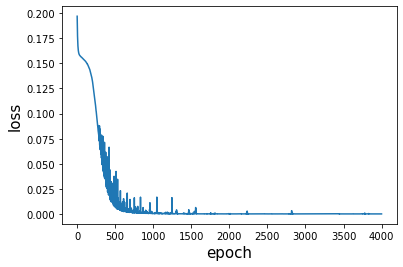

In [45]:
plt.plot(history.history["loss"])
plt.xlabel("epoch", fontsize=15)
plt.ylabel("loss", fontsize=15)
plt.show()

# Test the model after training

In [46]:
test_model(model, X_train, Y_train)

Correctly classified: 100.00


In [47]:
test_model(model, X_test, Y_test)

Correctly classified: 77.20


In [48]:
model.save("cnn_4000epochs")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: cnn_4000epochs/assets
